In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


In [2]:
%load_ext memory_profiler
%load_ext line_profiler
%load_ext timeit

The timeit module is not an IPython extension.


In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [10]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_category)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize=1024, overlap=512, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return np.array(items)

Overwriting load_blockwise.py


In [11]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2453.02 MiB, increment: 2149.00 MiB
CPU times: user 4min 21s, sys: 1.99 s, total: 4min 23s
Wall time: 4min 25s


In [12]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1747.55 MiB, increment: 449.62 MiB
CPU times: user 1min 4s, sys: 492 ms, total: 1min 4s
Wall time: 1min 4s


In [13]:
train_y = np.vstack([train_y, train_yy]).T
test_y = np.vstack([test_y, test_yy]).T

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [14]:
%%file cnnmult.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, InputLayer
from kapre.time_frequency import Melspectrogram, Spectrogram

from keras.wrappers.scikit_learn import KerasClassifier

SR=16000

class CNN_Multilayer(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=128, validation_split=0.05,
                       a_epochs=50, a_batch_size=128,
                       i_epochs=50, i_batch_size=128,
                       verbose=1):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=SR * 5,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KerasClassifier(build_fn=self.deep_net_a,
                                       feature_count=SR * 5,
                                       epochs=self.a_epochs, 
                                       batch_size=self.a_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KerasClassifier(build_fn=self.deep_net_i, 
                                       feature_count=SR * 5,
                                       epochs=self.i_epochs, 
                                       batch_size=self.i_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None):
        predictions=[]
        
        for x in X:
            prob = self.clf.predict_proba(x, verbose=0).squeeze()
            if prob[0] > 0.75:
                pred = self.a_clf.predict(x, verbose=0).squeeze()
            elif prob[1] > 0.75:
                pred = self.i_clf.predict(x, verbose=0).squeeze()
            else:
                a_pred = self.a_clf.predict(x, verbose=0).squeeze()
                i_pred = self.i_clf.predict(x, verbose=0).squeeze()
                
                a_prob = self.a_clf.predict_proba(x, verbose=0).squeeze() * prob[0]
                i_prob = self.i_clf.predict_proba(x, verbose=0).squeeze() * prob[1]
                
                if(np.max(a_prob) > np.max(i_prob)):
                    pred = a_pred
                else:
                    pred = i_pred
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()

        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze(),prob[0])

        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze(),prob[1])
        
        probs = [None] * 50
        for counter, j in enumerate(self.a_clf.classes_):
            probs[j] = prob_a[counter]
        for counter, j in enumerate(self.i_clf.classes_):
            probs[j] = prob_i[counter]
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        model.summary()


        return model

    def deep_net_a(self, feature_count):
        # Create Model
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(18, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    def deep_net_i(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

Overwriting cnnmult.py


In [15]:
from cnnmult import CNN_Multilayer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

clf = CNN_Multilayer()

clf.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

972/972 [==============================] - 28s 29ms/step - loss: 2.5854 - acc: 0.2233 - val_loss: 2.5107 - val_acc: 0.2308
Epoch 20/50
972/972 [==============================] - 29s 29ms/step - loss: 2.5237 - acc: 0.2531 - val_loss: 2.3309 - val_acc: 0.2692
Epoch 21/50
972/972 [==============================] - 29s 30ms/step - loss: 2.4459 - acc: 0.2418 - val_loss: 2.4209 - val_acc: 0.2500
Epoch 22/50
972/972 [==============================] - 27s 27ms/step - loss: 2.4187 - acc: 0.2665 - val_loss: 2.4014 - val_acc: 0.2500
Epoch 23/50
972/972 [==============================] - 27s 28ms/step - loss: 2.4116 - acc: 0.2747 - val_loss: 2.1212 - val_acc: 0.3846
Epoch 24/50
972/972 [==============================] - 28s 29ms/step - loss: 2.3643 - acc: 0.2562 - val_loss: 2.3621 - val_acc: 0.2885
Epoch 25/50
972/972 [==============================] - 27s 28ms/step - loss: 2.3341 - acc: 0.2912 - val_loss: 2.1890 - val_acc: 0.3077
Epoch 26/50
972/972 [==============================] - 27s 28ms/ste

CNN_Multilayer(a_batch_size=128, a_epochs=50, batch_size=128, epochs=50,
        i_batch_size=128, i_epochs=50, validation_split=0.05, verbose=1)

In [16]:
print(test_X[:, np.newaxis, :, :].shape)

(400, 1, 1, 80000)


0.305
Confusion matrix, without normalization
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 1 0]]


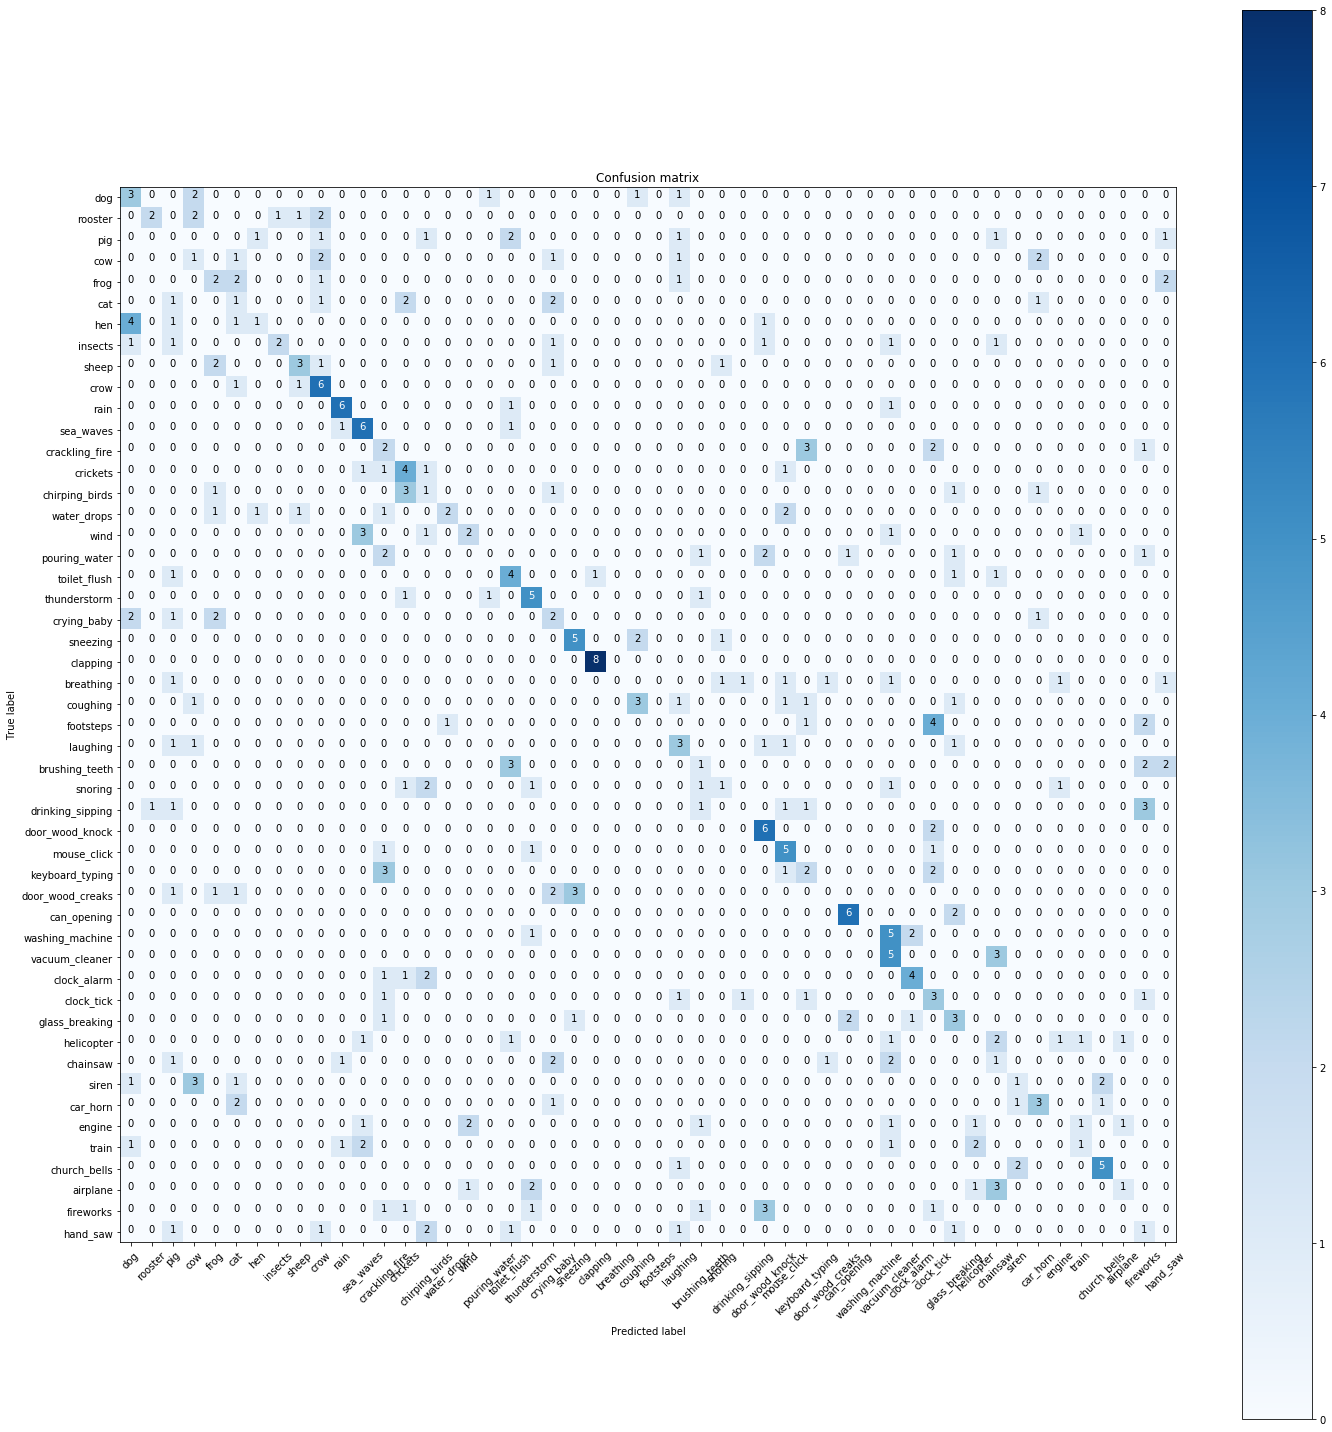

In [17]:
pred = clf.predict(test_X[:, np.newaxis, :, :])
print(metrics.accuracy_score(test_y[:,1], pred))
cm = metrics.confusion_matrix(test_y[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [18]:
%%time
import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

test = dataset[dataset.fold == 1].reset_index()
    
for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



	File Time: 0.29895925521850586
	File Time: 0.22042155265808105
	File Time: 0.22530126571655273
	File Time: 0.21338939666748047
	File Time: 0.2319958209991455
	File Time: 0.22351360321044922
	File Time: 0.18844985961914062
	File Time: 0.18269586563110352
	File Time: 0.1723639965057373
	File Time: 0.18082427978515625
	File Time: 0.17352914810180664
	File Time: 0.18726491928100586
	File Time: 0.1810595989227295
	File Time: 0.17285966873168945
	File Time: 0.18671846389770508
	File Time: 0.17904281616210938
	File Time: 0.17643499374389648
	File Time: 0.18131422996520996
	File Time: 0.2470250129699707
	File Time: 0.22583651542663574
	File Time: 0.25307321548461914
	File Time: 0.21988844871520996
	File Time: 0.21439456939697266
	File Time: 0.19686031341552734
	File Time: 0.18474936485290527
	File Time: 0.17679667472839355
	File Time: 0.19929170608520508
	File Time: 0.1883690357208252
	File Time: 0.17910552024841309
	File Time: 0.21569275856018066
	File Time: 0.18865513801574707
	File Time: 0

	File Time: 0.2025136947631836
	File Time: 0.20267677307128906
	File Time: 0.20631861686706543
	File Time: 0.20072197914123535
	File Time: 0.3032557964324951
	File Time: 0.27310848236083984
	File Time: 0.24913859367370605
	File Time: 0.24080610275268555
	File Time: 0.2747056484222412
	File Time: 0.23415422439575195
	File Time: 0.20920825004577637
	File Time: 0.2646164894104004
	File Time: 0.2630126476287842
	File Time: 0.25093865394592285
	File Time: 0.2345895767211914
	File Time: 0.23325085639953613
	File Time: 0.26453518867492676
	File Time: 0.2399752140045166
	File Time: 0.19818329811096191
	File Time: 0.19703269004821777
	File Time: 0.19786381721496582
	File Time: 0.22098636627197266
	File Time: 0.2302706241607666
	File Time: 0.2079477310180664
	File Time: 0.20374751091003418
	File Time: 0.19533038139343262
	File Time: 0.19816923141479492
	File Time: 0.20084881782531738
	File Time: 0.2960681915283203
	File Time: 0.26342344284057617
	File Time: 0.200577974319458
	File Time: 0.258093

0.305
Confusion matrix, without normalization
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 1 0]]


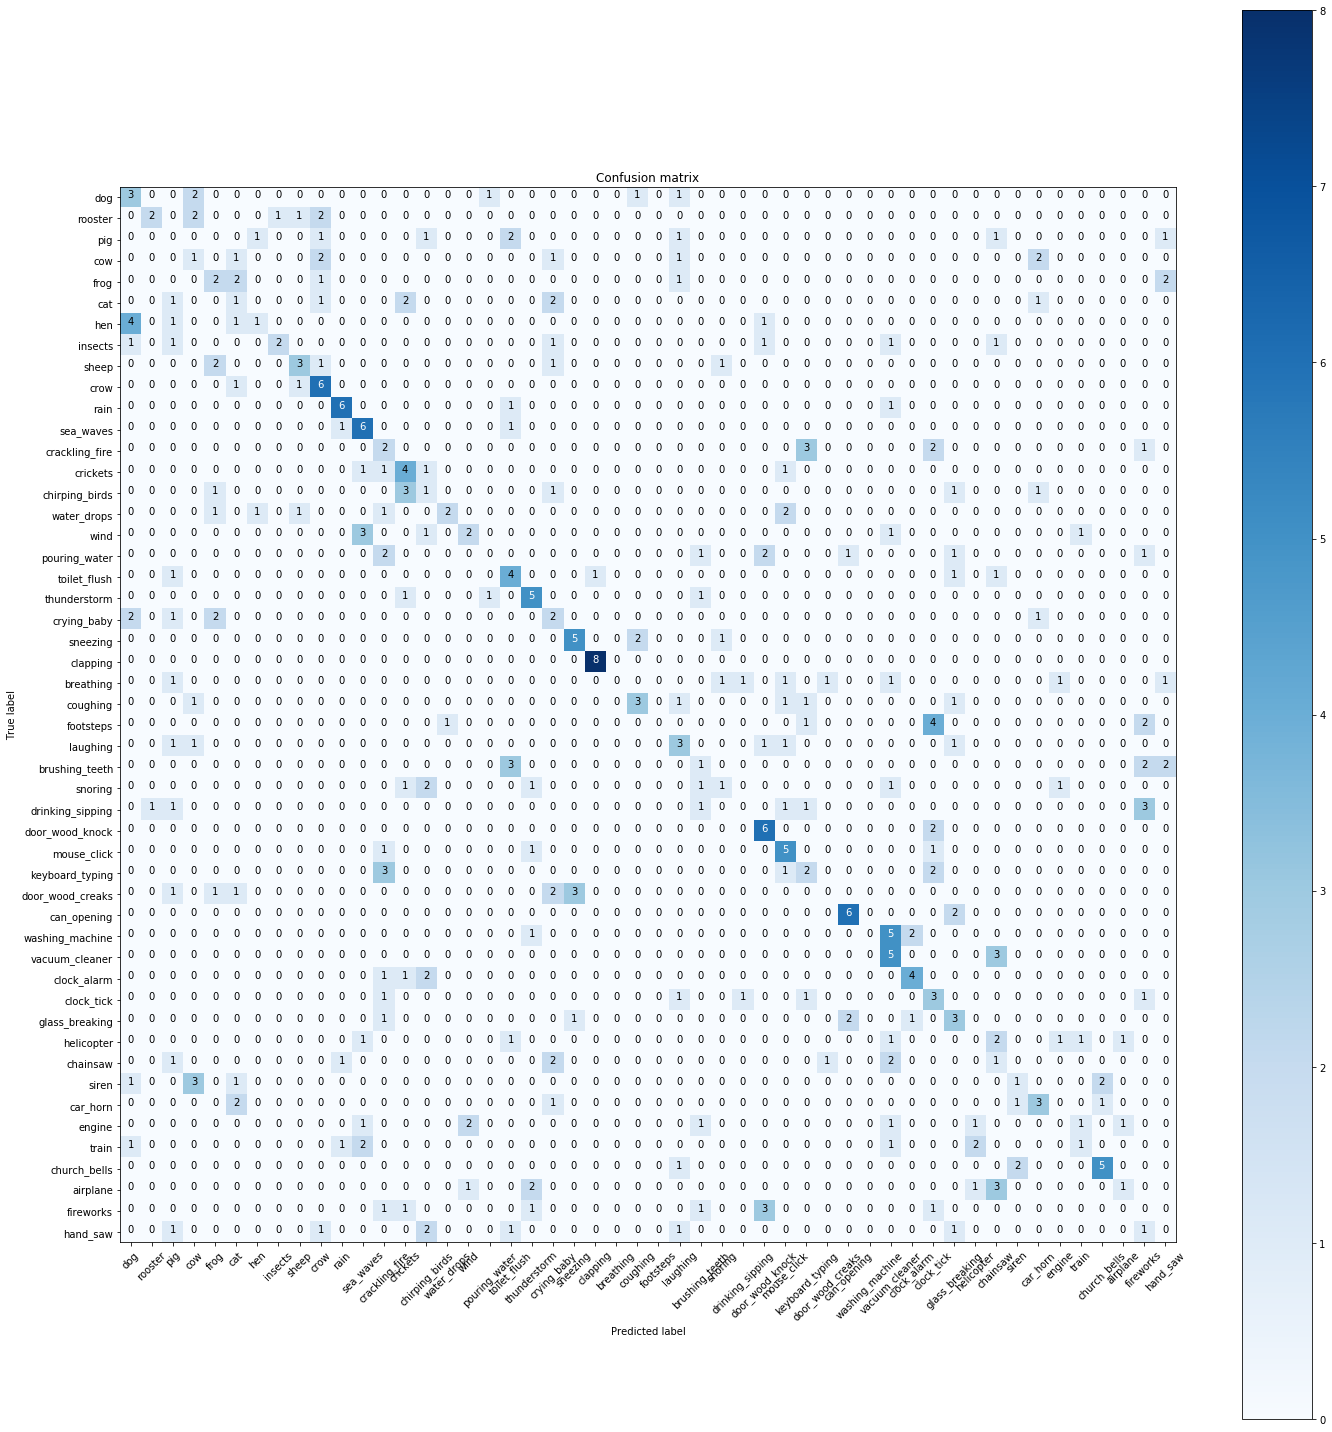

In [19]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [20]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)
    
    predictions = []

    for data_iloc in range(0,len(test)):
        x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                             blocksize=orig_blocksize,
                             overlap=orig_overlap)[0]

        prob = clf.predict_proba(x_file)[l_l]
        pred = clf.predict(x_file[np.newaxis, :, :, :])
        
        predictions.append({
            'file': test.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': prob,
            'prediction': pred
        })
        
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    return predictions

In [21]:
%%time
preds = query_dataset('dog')

CPU times: user 7min 53s, sys: 1min 9s, total: 9min 3s
Wall time: 1min 45s


In [22]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
#     print(misclass)
    return (count - len(misclass))/count

In [23]:
# Checking index
check_accuracy(preds, 'dog', 10)

0.2

In [24]:
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 8min 4s, sys: 1min 7s, total: 9min 12s
Wall time: 1min 44s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11 ms
dog
0.2

CPU times: user 8min 3s, sys: 1min 21s, total: 9min 24s
Wall time: 1min 44s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 11.1 ms
rooster
0.4

CPU times: user 7min 53s, sys: 1min 35s, total: 9min 28s
Wall time: 1min 44s
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 11 ms
pig
0.1

CPU times: user 7min 31s, sys: 1min 59s, total: 9min 30s
Wall time: 1min 46s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.2 ms
cow
0.1

CPU times: user 7min 56s, sys: 1min 18s, total: 9min 14s
Wall time: 1min 44s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.9 ms
frog
0.2

CPU times: user 7min 52s, sys: 1min 13s, total: 9min 5s
Wall time: 1min 43s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.3 ms
cat
0.1

CPU times: user 7min 59s, sys: 1min 15s, total: 9min 15s
Wall time: 1min 43s
CPU times: user 8 ms

0.274